# Joint Maximum Mean Discrepancy (JMMD) for Image-to-Image Translation

This notebook implements JMMD for unsupervised image-to-image translation using convolutional generators. The JMMD loss is computed at 3 consecutive layers including the bottleneck layer for effective domain adaptation.

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, Model, optimizers, losses
import os
import sys

In [15]:
class JMMDLoss(keras.layers.Layer):
    """
    Joint Maximum Mean Discrepancy Loss in TensorFlow
    Computes JMMD across multiple feature layers
    """
    def __init__(self, kernel_type='rbf', kernel_mul=2.0, kernel_num=5, fix_sigma=None, **kwargs):
        super(JMMDLoss, self).__init__(**kwargs)
        self.kernel_type = kernel_type
        self.kernel_mul = kernel_mul
        self.kernel_num = kernel_num
        self.fix_sigma = fix_sigma
    
    def gaussian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        """
        Compute Gaussian kernel matrix
        """
        n_samples = tf.shape(source)[0] + tf.shape(target)[0]
        total = tf.concat([source, target], axis=0)
        
        # Compute pairwise distances
        total_expanded_1 = tf.expand_dims(total, 1)  # [n, 1, d]
        total_expanded_2 = tf.expand_dims(total, 0)  # [1, n, d]
        
        L2_distance = tf.reduce_sum(tf.square(total_expanded_1 - total_expanded_2), axis=2)
        
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = tf.reduce_sum(L2_distance) / tf.cast(n_samples ** 2 - n_samples, tf.float32)
        
        bandwidth = bandwidth / (kernel_mul ** (kernel_num // 2))
        bandwidth_list = [bandwidth * (kernel_mul ** i) for i in range(kernel_num)]
        
        kernel_val = [tf.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
        return tf.reduce_sum(kernel_val, axis=0)
    
    def mmd(self, source, target):
        """
        Compute MMD between source and target
        """
        batch_size = tf.shape(source)[0]
        kernels = self.gaussian_kernel(source, target, 
                                    kernel_mul=self.kernel_mul, 
                                    kernel_num=self.kernel_num, 
                                    fix_sigma=self.fix_sigma)
        
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        
        loss = tf.reduce_mean(XX + YY - XY - YX)
        return loss
    
    def call(self, source_list, target_list):
        """
        Compute JMMD across multiple layers
        source_list: list of source features from different layers
        target_list: list of target features from different layers
        """
        jmmd_loss = 0.0
        for source_feat, target_feat in zip(source_list, target_list):
            # Flatten features if needed
            if len(source_feat.shape) > 2:
                source_feat = tf.reshape(source_feat, [tf.shape(source_feat)[0], -1])
                target_feat = tf.reshape(target_feat, [tf.shape(target_feat)[0], -1])
            
            jmmd_loss += self.mmd(source_feat, target_feat)
        
        return jmmd_loss / len(source_list)

In [16]:
class ConvGenerator(Model):
    """
    Convolutional Generator for Image-to-Image Translation
    Uses encoder-decoder architecture with skip connections
    """
    def __init__(self, input_shape=(64, 64, 3), **kwargs):
        super(ConvGenerator, self).__init__(**kwargs)
        
        self.input_shape = input_shape
        
        # Encoder (Downsampling)
        self.conv1 = layers.Conv2D(64, (4, 4), strides=2, padding='same', activation='relu')
        self.bn1 = layers.BatchNormalization()
        
        self.conv2 = layers.Conv2D(128, (4, 4), strides=2, padding='same', activation='relu')
        self.bn2 = layers.BatchNormalization()
        
        self.conv3 = layers.Conv2D(256, (4, 4), strides=2, padding='same', activation='relu')
        self.bn3 = layers.BatchNormalization()
        
        # Bottleneck
        self.bottleneck = layers.Conv2D(512, (4, 4), strides=2, padding='same', activation='relu')
        self.bn_bottleneck = layers.BatchNormalization()
        
        # Decoder (Upsampling)
        self.deconv1 = layers.Conv2DTranspose(256, (4, 4), strides=2, padding='same', activation='relu')
        self.bn_dec1 = layers.BatchNormalization()
        
        self.deconv2 = layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same', activation='relu')
        self.bn_dec2 = layers.BatchNormalization()
        
        self.deconv3 = layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same', activation='relu')
        self.bn_dec3 = layers.BatchNormalization()
        
        # Output layer
        self.output_conv = layers.Conv2DTranspose(3, (4, 4), strides=2, padding='same', activation='tanh')
        
        self.dropout = layers.Dropout(0.5)
    
    def call(self, x, return_features=False, training=None):
        features = []
        
        # Encoder
        x1 = self.conv1(x, training=training)
        x1 = self.bn1(x1, training=training)
        
        x2 = self.conv2(x1, training=training)
        x2 = self.bn2(x2, training=training)
        if return_features:
            features.append(tf.reshape(x2, [tf.shape(x2)[0], -1]))  # Feature layer 1
        
        x3 = self.conv3(x2, training=training)
        x3 = self.bn3(x3, training=training)
        if return_features:
            features.append(tf.reshape(x3, [tf.shape(x3)[0], -1]))  # Feature layer 2
        
        # Bottleneck
        bottleneck = self.bottleneck(x3, training=training)
        bottleneck = self.bn_bottleneck(bottleneck, training=training)
        bottleneck = self.dropout(bottleneck, training=training)
        if return_features:
            features.append(tf.reshape(bottleneck, [tf.shape(bottleneck)[0], -1]))  # Bottleneck layer
        
        # Decoder with skip connections
        d1 = self.deconv1(bottleneck, training=training)
        d1 = self.bn_dec1(d1, training=training)
        d1 = tf.concat([d1, x3], axis=-1)  # Skip connection
        
        d2 = self.deconv2(d1, training=training)
        d2 = self.bn_dec2(d2, training=training)
        d2 = tf.concat([d2, x2], axis=-1)  # Skip connection
        
        d3 = self.deconv3(d2, training=training)
        d3 = self.bn_dec3(d3, training=training)
        d3 = tf.concat([d3, x1], axis=-1)  # Skip connection
        
        # Output
        output = self.output_conv(d3, training=training)
        
        if return_features:
            return output, features
        return output

class ConvDiscriminator(Model):
    """
    Convolutional Discriminator for Image-to-Image Translation
    PatchGAN discriminator for better texture discrimination
    """
    def __init__(self, input_shape=(64, 64, 3), **kwargs):
        super(ConvDiscriminator, self).__init__(**kwargs)
        
        self.conv1 = layers.Conv2D(64, (4, 4), strides=2, padding='same')
        self.leaky1 = layers.LeakyReLU(alpha=0.2)
        
        self.conv2 = layers.Conv2D(128, (4, 4), strides=2, padding='same')
        self.bn2 = layers.BatchNormalization()
        self.leaky2 = layers.LeakyReLU(alpha=0.2)
        
        self.conv3 = layers.Conv2D(256, (4, 4), strides=2, padding='same')
        self.bn3 = layers.BatchNormalization()
        self.leaky3 = layers.LeakyReLU(alpha=0.2)
        
        self.conv4 = layers.Conv2D(512, (4, 4), strides=1, padding='same')
        self.bn4 = layers.BatchNormalization()
        self.leaky4 = layers.LeakyReLU(alpha=0.2)
        
        # Output patch
        self.output_conv = layers.Conv2D(1, (4, 4), strides=1, padding='same', activation='sigmoid')
    
    def call(self, x, training=None):
        x = self.conv1(x, training=training)
        x = self.leaky1(x)
        
        x = self.conv2(x, training=training)
        x = self.bn2(x, training=training)
        x = self.leaky2(x)
        
        x = self.conv3(x, training=training)
        x = self.bn3(x, training=training)
        x = self.leaky3(x)
        
        x = self.conv4(x, training=training)
        x = self.bn4(x, training=training)
        x = self.leaky4(x)
        
        output = self.output_conv(x, training=training)
        
        return output

In [ ]:
class ImageToImageJMMD:
    """
    Image-to-Image Translation with JMMD Domain Adaptation
    """
    def __init__(self, generator, discriminator, lambda_jmmd=10.0, lambda_adv=1.0, lambda_l1=100.0):
        self.generator = generator
        self.discriminator = discriminator
        self.jmmd_loss = JMMDLoss()
        self.lambda_jmmd = lambda_jmmd
        self.lambda_adv = lambda_adv
        self.lambda_l1 = lambda_l1
        
        self.gen_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        self.disc_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        self.adversarial_loss = losses.BinaryCrossentropy()
        self.l1_loss = losses.MeanAbsoluteError()
    
    @tf.function
    def train_discriminator_step(self, real_A, real_B, fake_B):
        """
        Train discriminator to distinguish real vs fake images
        """
        with tf.GradientTape() as tape:
            # Real images (concatenate input A with target B)
            real_AB = tf.concat([real_A, real_B], axis=-1)
            real_pred = self.discriminator(real_AB, training=True)
            real_loss = self.adversarial_loss(tf.ones_like(real_pred), real_pred)
            
            # Fake images (concatenate input A with generated B)
            fake_AB = tf.concat([real_A, fake_B], axis=-1)
            fake_pred = self.discriminator(fake_AB, training=True)
            fake_loss = self.adversarial_loss(tf.zeros_like(fake_pred), fake_pred)
            
            total_disc_loss = (real_loss + fake_loss) * 0.5
        
        gradients = tape.gradient(total_disc_loss, self.discriminator.trainable_variables)
        self.disc_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))
        
        return total_disc_loss
    
    @tf.function
    def train_generator_step(self, source_A, source_B, target_A, target_B=None):
        """
        Train generator with L1, adversarial, and JMMD losses
        """
        with tf.GradientTape() as tape:
            # Generate images
            fake_source_B, source_features = self.generator(source_A, return_features=True, training=True)
            fake_target_B, target_features = self.generator(target_A, return_features=True, training=True)
            
            # L1 loss (only for source domain where we have ground truth)
            l1_loss = self.l1_loss(source_B, fake_source_B)
            
            # Adversarial loss
            fake_AB = tf.concat([source_A, fake_source_B], axis=-1)
            fake_pred = self.discriminator(fake_AB, training=False)
            adv_loss = self.adversarial_loss(tf.ones_like(fake_pred), fake_pred)
            
            # JMMD loss between source and target features (3 layers)
            jmmd_loss = self.jmmd_loss(source_features, target_features)
            
            # Total generator loss
            total_loss = (self.lambda_l1 * l1_loss + 
                         self.lambda_adv * adv_loss + 
                         self.lambda_jmmd * jmmd_loss)
        
        gradients = tape.gradient(total_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))
        
        return {
            'total_loss': total_loss,
            'l1_loss': l1_loss,
            'adv_loss': adv_loss,
            'jmmd_loss': jmmd_loss
        }
    
    def train_with_8_loaders(self, 
                        loader_H_input_train_source, loader_H_true_train_source,
                        loader_H_input_train_target, loader_H_true_train_target,
                        loader_H_input_val_source=None, loader_H_true_val_source=None,
                        loader_H_input_val_target=None, loader_H_true_val_target=None,
                        epochs=100):
        """
        Train the image-to-image translation model with 8 separate loaders
        """
        history = {
            'total_loss': [], 'l1_loss': [], 'adv_loss': [], 
            'jmmd_loss': [], 'disc_loss': []
        }
        
        for epoch in range(epochs):
            epoch_losses = {
                'total_loss': 0.0, 'l1_loss': 0.0, 'adv_loss': 0.0,
                'jmmd_loss': 0.0, 'disc_loss': 0.0
            }
            
            # Create iterators for all loaders
            source_A_iter = iter(loader_H_input_train_source)
            source_B_iter = iter(loader_H_true_train_source)
            target_A_iter = iter(loader_H_input_train_target)
            target_B_iter = iter(loader_H_true_train_target)
            
            # Calculate number of batches based on shortest loader
            num_batches = min(
                len(loader_H_input_train_source),
                len(loader_H_true_train_source),
                len(loader_H_input_train_target),
                len(loader_H_true_train_target)
            )
            
            for batch_idx in range(num_batches):
                # Get source domain data
                try:
                    source_A = next(source_A_iter)
                    source_B = next(source_B_iter)
                except StopIteration:
                    source_A_iter = iter(loader_H_input_train_source)
                    source_B_iter = iter(loader_H_true_train_source)
                    source_A = next(source_A_iter)
                    source_B = next(source_B_iter)
                
                # Get target domain data
                try:
                    target_A = next(target_A_iter)
                    target_B = next(target_B_iter)  # Available but not used for training
                except StopIteration:
                    target_A_iter = iter(loader_H_input_train_target)
                    target_B_iter = iter(loader_H_true_train_target)
                    target_A = next(target_A_iter)
                    target_B = next(target_B_iter)
                
                # Train generator
                gen_losses = self.train_generator_step(source_A, source_B, target_A)
                
                # Generate fake images for discriminator training
                fake_B = self.generator(source_A, training=False)
                
                # Train discriminator
                disc_loss = self.train_discriminator_step(source_A, source_B, fake_B)
                
                # Accumulate losses
                for key in gen_losses:
                    epoch_losses[key] += float(gen_losses[key])
                epoch_losses['disc_loss'] += float(disc_loss)
            
            # Average losses
            for key in epoch_losses:
                epoch_losses[key] /= num_batches
                history[key].append(epoch_losses[key])
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}:")
                print(f"  Total Loss: {epoch_losses['total_loss']:.4f}")
                print(f"  L1 Loss: {epoch_losses['l1_loss']:.4f}")
                print(f"  Adversarial Loss: {epoch_losses['adv_loss']:.4f}")
                print(f"  JMMD Loss: {epoch_losses['jmmd_loss']:.4f}")
                print(f"  Discriminator Loss: {epoch_losses['disc_loss']:.4f}")
                print()
        
        return history
    
    def train(self, source_loader, target_loader, epochs=100):
        """
        Train the image-to-image translation model (legacy method for compatibility)
        """
        history = {
            'total_loss': [], 'l1_loss': [], 'adv_loss': [], 
            'jmmd_loss': [], 'disc_loss': []
        }
        
        for epoch in range(epochs):
            epoch_losses = {
                'total_loss': 0.0, 'l1_loss': 0.0, 'adv_loss': 0.0,
                'jmmd_loss': 0.0, 'disc_loss': 0.0
            }
            
            # Create iterators
            source_iter = iter(source_loader)
            target_iter = iter(target_loader)
            
            num_batches = min(len(source_loader), len(target_loader))
            
            for batch_idx in range(num_batches):
                # Get source batch (A, B pairs)
                try:
                    source_A, source_B = next(source_iter)
                except StopIteration:
                    source_iter = iter(source_loader)
                    source_A, source_B = next(source_iter)
                
                # Get target batch (only A, no ground truth B)
                try:
                    target_A, _ = next(target_iter)
                except StopIteration:
                    target_iter = iter(target_loader)
                    target_A, _ = next(target_iter)
                
                # Train generator
                gen_losses = self.train_generator_step(source_A, source_B, target_A)
                
                # Generate fake images for discriminator training
                fake_B = self.generator(source_A, training=False)
                
                # Train discriminator
                disc_loss = self.train_discriminator_step(source_A, source_B, fake_B)
                
                # Accumulate losses
                for key in gen_losses:
                    epoch_losses[key] += float(gen_losses[key])
                epoch_losses['disc_loss'] += float(disc_loss)
            
            # Average losses
            for key in epoch_losses:
                epoch_losses[key] /= num_batches
                history[key].append(epoch_losses[key])
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}:")
                print(f"  Total Loss: {epoch_losses['total_loss']:.4f}")
                print(f"  L1 Loss: {epoch_losses['l1_loss']:.4f}")
                print(f"  Adversarial Loss: {epoch_losses['adv_loss']:.4f}")
                print(f"  JMMD Loss: {epoch_losses['jmmd_loss']:.4f}")
                print(f"  Discriminator Loss: {epoch_losses['disc_loss']:.4f}")
                print()
        
        return history

In [18]:
# Create synthetic datasets for image-to-image translation
import numpy as np

def create_synthetic_image_data(num_samples=1000, img_size=64):
    """
    Create synthetic image data for image-to-image translation
    Source domain: Simple geometric shapes
    Target domain: Same shapes with different colors/textures
    """
    def create_shapes_batch(batch_size, domain_type='source'):
        images_A = []  # Input images
        images_B = []  # Target images
        
        for _ in range(batch_size):
            # Create base image
            img_A = np.zeros((img_size, img_size, 3), dtype=np.float32)
            img_B = np.zeros((img_size, img_size, 3), dtype=np.float32)
            
            # Random shape type
            shape_type = np.random.choice(['circle', 'rectangle', 'triangle'])
            
            # Random position and size
            center_x = np.random.randint(img_size//4, 3*img_size//4)
            center_y = np.random.randint(img_size//4, 3*img_size//4)
            size = np.random.randint(img_size//8, img_size//4)
            
            if shape_type == 'circle':
                y, x = np.ogrid[:img_size, :img_size]
                mask = (x - center_x)**2 + (y - center_y)**2 <= size**2
                
                if domain_type == 'source':
                    # Source: Red circles
                    img_A[mask] = [1.0, 0.0, 0.0]
                    img_B[mask] = [0.0, 1.0, 0.0]  # Target: Green circles
                else:
                    # Target domain: Different color mapping
                    img_A[mask] = [0.8, 0.2, 0.0]  # Orange-ish input
                    img_B[mask] = [0.0, 0.0, 1.0]  # Target: Blue circles
            
            elif shape_type == 'rectangle':
                x1, x2 = max(0, center_x - size), min(img_size, center_x + size)
                y1, y2 = max(0, center_y - size), min(img_size, center_y + size)
                
                if domain_type == 'source':
                    # Source: Blue rectangles
                    img_A[y1:y2, x1:x2] = [0.0, 0.0, 1.0]
                    img_B[y1:y2, x1:x2] = [1.0, 1.0, 0.0]  # Target: Yellow rectangles
                else:
                    # Target domain: Different color mapping
                    img_A[y1:y2, x1:x2] = [0.0, 0.2, 0.8]  # Blue-ish input
                    img_B[y1:y2, x1:x2] = [1.0, 0.0, 1.0]  # Target: Magenta rectangles
            
            # Add some noise for domain variation
            if domain_type == 'target':
                noise_A = np.random.normal(0, 0.1, img_A.shape)
                noise_B = np.random.normal(0, 0.1, img_B.shape)
                img_A = np.clip(img_A + noise_A, 0, 1)
                img_B = np.clip(img_B + noise_B, 0, 1)
            
            images_A.append(img_A)
            images_B.append(img_B)
        
        return np.array(images_A), np.array(images_B)
    
    # Create source domain data (with ground truth pairs)
    source_A, source_B = create_shapes_batch(num_samples, 'source')
    
    # Create target domain data (different style, no ground truth for B)
    target_A, target_B = create_shapes_batch(num_samples, 'target')
    
    return source_A, source_B, target_A, target_B

# Generate synthetic data
print("Creating synthetic image datasets...")
source_A, source_B, target_A, target_B = create_synthetic_image_data(num_samples=800, img_size=64)

print(f"Source domain A (input): {source_A.shape}")
print(f"Source domain B (target): {source_B.shape}")
print(f"Target domain A (input): {target_A.shape}")
print(f"Target domain B (target): {target_B.shape}")

# Normalize to [-1, 1] for tanh activation
source_A = source_A * 2.0 - 1.0
source_B = source_B * 2.0 - 1.0
target_A = target_A * 2.0 - 1.0
target_B = target_B * 2.0 - 1.0

print("Data normalized to [-1, 1] range")

Creating synthetic image datasets...
Source domain A (input): (800, 64, 64, 3)
Source domain B (target): (800, 64, 64, 3)
Target domain A (input): (800, 64, 64, 3)
Target domain B (target): (800, 64, 64, 3)
Data normalized to [-1, 1] range
Source domain A (input): (800, 64, 64, 3)
Source domain B (target): (800, 64, 64, 3)
Target domain A (input): (800, 64, 64, 3)
Target domain B (target): (800, 64, 64, 3)
Data normalized to [-1, 1] range


In [19]:
# Split data and create data loaders
from sklearn.model_selection import train_test_split

# Split source domain
source_A_train, source_A_val, source_B_train, source_B_val = train_test_split(
    source_A, source_B, test_size=0.2, random_state=42
)

# Split target domain  
target_A_train, target_A_val, target_B_train, target_B_val = train_test_split(
    target_A, target_B, test_size=0.2, random_state=42
)

print(f"Training splits:")
print(f"Source: A={source_A_train.shape}, B={source_B_train.shape}")
print(f"Target: A={target_A_train.shape}, B={target_B_train.shape}")
print(f"Validation splits:")
print(f"Source: A={source_A_val.shape}, B={source_B_val.shape}")
print(f"Target: A={target_A_val.shape}, B={target_B_val.shape}")

Training splits:
Source: A=(640, 64, 64, 3), B=(640, 64, 64, 3)
Target: A=(640, 64, 64, 3), B=(640, 64, 64, 3)
Validation splits:
Source: A=(160, 64, 64, 3), B=(160, 64, 64, 3)
Target: A=(160, 64, 64, 3), B=(160, 64, 64, 3)


In [20]:
# Create data structure to mimic class_dict_source and class_dict_target
class DataLoaders:
    """Simple class to hold data loaders"""
    def __init__(self, input_train, true_train, input_val, true_val):
        self.input_train = input_train
        self.true_train = true_train
        self.input_val = input_val
        self.true_val = true_val

# Create TensorFlow datasets for image-to-image translation
batch_size = 16
sub_folder = 'default'  # Can be changed to different subfolder names

# Create separate A and B loaders for source domain
source_A_train_loader = tf.data.Dataset.from_tensor_slices(source_A_train).batch(batch_size).prefetch(tf.data.AUTOTUNE)
source_B_train_loader = tf.data.Dataset.from_tensor_slices(source_B_train).batch(batch_size).prefetch(tf.data.AUTOTUNE)
source_A_val_loader = tf.data.Dataset.from_tensor_slices(source_A_val).batch(batch_size).prefetch(tf.data.AUTOTUNE)
source_B_val_loader = tf.data.Dataset.from_tensor_slices(source_B_val).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Create separate A and B loaders for target domain
target_A_train_loader = tf.data.Dataset.from_tensor_slices(target_A_train).batch(batch_size).prefetch(tf.data.AUTOTUNE)
target_B_train_loader = tf.data.Dataset.from_tensor_slices(target_B_train).batch(batch_size).prefetch(tf.data.AUTOTUNE)
target_A_val_loader = tf.data.Dataset.from_tensor_slices(target_A_val).batch(batch_size).prefetch(tf.data.AUTOTUNE)
target_B_val_loader = tf.data.Dataset.from_tensor_slices(target_B_val).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Create class_dict structure
class_dict_source = {
    sub_folder: DataLoaders(
        input_train=source_A_train_loader,
        true_train=source_B_train_loader,
        input_val=source_A_val_loader,
        true_val=source_B_val_loader
    )
}

class_dict_target = {
    sub_folder: DataLoaders(
        input_train=target_A_train_loader,
        true_train=target_B_train_loader,
        input_val=target_A_val_loader,
        true_val=target_B_val_loader
    )
}

# Create the 8 loaders as requested
loader_H_true_train_source = class_dict_source[sub_folder].true_train
loader_H_input_train_source = class_dict_source[sub_folder].input_train
loader_H_true_val_source = class_dict_source[sub_folder].true_val
loader_H_input_val_source = class_dict_source[sub_folder].input_val

loader_H_true_train_target = class_dict_target[sub_folder].true_train
loader_H_input_train_target = class_dict_target[sub_folder].input_train
loader_H_true_val_target = class_dict_target[sub_folder].true_val
loader_H_input_val_target = class_dict_target[sub_folder].input_val

# Additional test loader (commonly used)
loader_H_test_target = loader_H_input_val_target

print("8 Data Loaders Created Successfully:")
print("Source Domain:")
print("✓ loader_H_true_train_source (B data for training)")
print("✓ loader_H_input_train_source (A data for training)")
print("✓ loader_H_true_val_source (B data for validation)")
print("✓ loader_H_input_val_source (A data for validation)")
print("\nTarget Domain:")
print("✓ loader_H_true_train_target (B data for training)")
print("✓ loader_H_input_train_target (A data for training)")
print("✓ loader_H_true_val_target (B data for validation)")
print("✓ loader_H_input_val_target (A data for validation)")
print(f"\n✓ Sub-folder: '{sub_folder}'")
print(f"✓ Batch size: {batch_size}")
print(f"✓ Image size: 64×64×3")
print("✓ Data range: [-1, 1]")

8 Data Loaders Created Successfully:
Source Domain:
✓ loader_H_true_train_source (B data for training)
✓ loader_H_input_train_source (A data for training)
✓ loader_H_true_val_source (B data for validation)
✓ loader_H_input_val_source (A data for validation)

Target Domain:
✓ loader_H_true_train_target (B data for training)
✓ loader_H_input_train_target (A data for training)
✓ loader_H_true_val_target (B data for validation)
✓ loader_H_input_val_target (A data for validation)

✓ Sub-folder: 'default'
✓ Batch size: 16
✓ Image size: 64×64×3
✓ Data range: [-1, 1]


In [21]:
# Initialize Image-to-Image Translation with JMMD
print(f"Using TensorFlow version: {tf.__version__}")

# Create convolutional generator and discriminator
generator = ConvGenerator(input_shape=(64, 64, 3))
discriminator = ConvDiscriminator(input_shape=(64, 64, 6))  # 6 channels for concatenated A+B

# Build models
dummy_input = tf.random.normal([1, 64, 64, 3])
dummy_concat = tf.random.normal([1, 64, 64, 6])
_ = generator(dummy_input)
_ = discriminator(dummy_concat)

# Initialize image-to-image JMMD trainer
img2img_jmmd = ImageToImageJMMD(
    generator=generator,
    discriminator=discriminator,
    lambda_jmmd=10.0,   # Higher weight for domain adaptation
    lambda_adv=1.0,     # Standard adversarial weight
    lambda_l1=100.0     # High L1 weight for structure preservation
)

print("Image-to-Image JMMD model initialized!")
print(f"Generator parameters: {generator.count_params():,}")
print(f"Discriminator parameters: {discriminator.count_params():,}")

print("\nArchitecture Details:")
print("• Generator: Encoder-Decoder with skip connections")
print("• JMMD computed at 3 layers: conv2 → conv3 → bottleneck")
print("• Discriminator: PatchGAN for texture discrimination")

print(f"\nHyperparameters:")
print(f"• L1 weight (λ_L1): {img2img_jmmd.lambda_l1}")
print(f"• JMMD weight (λ_JMMD): {img2img_jmmd.lambda_jmmd}")
print(f"• Adversarial weight (λ_adv): {img2img_jmmd.lambda_adv}")
print(f"• Learning rate: {img2img_jmmd.gen_optimizer.learning_rate.numpy()}")

print("\nReady for image-to-image translation training with JMMD!")

Using TensorFlow version: 2.19.0
Image-to-Image JMMD model initialized!
Generator parameters: 6,176,643
Discriminator parameters: 2,771,393

Architecture Details:
• Generator: Encoder-Decoder with skip connections
• JMMD computed at 3 layers: conv2 → conv3 → bottleneck
• Discriminator: PatchGAN for texture discrimination

Hyperparameters:
• L1 weight (λ_L1): 100.0
• JMMD weight (λ_JMMD): 10.0
• Adversarial weight (λ_adv): 1.0
• Learning rate: 0.00019999999494757503

Ready for image-to-image translation training with JMMD!
Image-to-Image JMMD model initialized!
Generator parameters: 6,176,643
Discriminator parameters: 2,771,393

Architecture Details:
• Generator: Encoder-Decoder with skip connections
• JMMD computed at 3 layers: conv2 → conv3 → bottleneck
• Discriminator: PatchGAN for texture discrimination

Hyperparameters:
• L1 weight (λ_L1): 100.0
• JMMD weight (λ_JMMD): 10.0
• Adversarial weight (λ_adv): 1.0
• Learning rate: 0.00019999999494757503

Ready for image-to-image translati

In [22]:
# Test the image-to-image model with 8 loaders
def test_img2img_model_8_loaders():
    """
    Test the image-to-image translation model with 8 separate loaders
    """
    print("Testing image-to-image translation model with 8 loaders...")
    
    # Get test batches from separate loaders
    source_A = next(iter(loader_H_input_train_source))
    source_B = next(iter(loader_H_true_train_source))
    target_A = next(iter(loader_H_input_train_target))
    target_B = next(iter(loader_H_true_train_target))
    
    print(f"Source A shape: {source_A.shape}")
    print(f"Source B shape: {source_B.shape}")
    print(f"Target A shape: {target_A.shape}")
    print(f"Target B shape: {target_B.shape}")
    
    try:
        # Test generator forward pass
        fake_B, features = generator(source_A[:2], return_features=True, training=False)
        print(f"Generated B shape: {fake_B.shape}")
        print(f"Number of feature layers: {len(features)}")
        print(f"Feature shapes: {[f.shape for f in features]}")
        
        # Test discriminator
        concat_real = tf.concat([source_A[:2], source_B[:2]], axis=-1)
        real_pred = discriminator(concat_real, training=False)
        print(f"Discriminator output shape: {real_pred.shape}")
        
        # Test JMMD loss
        _, target_features = generator(target_A[:2], return_features=True, training=False)
        jmmd_loss = img2img_jmmd.jmmd_loss(features, target_features)
        print(f"JMMD loss: {jmmd_loss.numpy():.4f}")
        
        print("✅ Image-to-image model test with 8 loaders passed!")
        return True
        
    except Exception as e:
        print(f"❌ Model test failed: {e}")
        return False

def test_8_loaders_structure():
    """
    Test the 8-loader structure
    """
    print("Testing 8-loader structure...")
    print(f"Sub-folder: '{sub_folder}'")
    
    loaders = [
        ('loader_H_true_train_source', loader_H_true_train_source),
        ('loader_H_input_train_source', loader_H_input_train_source),
        ('loader_H_true_val_source', loader_H_true_val_source),
        ('loader_H_input_val_source', loader_H_input_val_source),
        ('loader_H_true_train_target', loader_H_true_train_target),
        ('loader_H_input_train_target', loader_H_input_train_target),
        ('loader_H_true_val_target', loader_H_true_val_target),
        ('loader_H_input_val_target', loader_H_input_val_target)
    ]
    
    print("\n8 Loaders Structure:")
    for name, loader in loaders:
        sample = next(iter(loader))
        print(f"✓ {name}: {sample.shape}")
    
    print(f"\nClass dict access test:")
    print(f"✓ class_dict_source['{sub_folder}'].input_train: Available")
    print(f"✓ class_dict_source['{sub_folder}'].true_train: Available")
    print(f"✓ class_dict_target['{sub_folder}'].input_train: Available")
    print(f"✓ class_dict_target['{sub_folder}'].true_train: Available")
    
    return True

# Run both tests
loader_test_success = test_8_loaders_structure()
model_test_success = test_img2img_model_8_loaders()

if loader_test_success and model_test_success:
    print("\n🚀 All tests passed! Model is ready for 8-loader training!")
    print("\nAvailable loaders:")
    print("📁 Source Domain:")
    print("  • loader_H_input_train_source (A data)")
    print("  • loader_H_true_train_source (B data)")
    print("  • loader_H_input_val_source (A validation)")
    print("  • loader_H_true_val_source (B validation)")
    print("📁 Target Domain:")
    print("  • loader_H_input_train_target (A data)")
    print("  • loader_H_true_train_target (B data)")
    print("  • loader_H_input_val_target (A validation)")
    print("  • loader_H_true_val_target (B validation)")
else:
    print("\n⚠️  Please check the configuration.")

Testing 8-loader structure...
Sub-folder: 'default'

8 Loaders Structure:
✓ loader_H_true_train_source: (16, 64, 64, 3)
✓ loader_H_input_train_source: (16, 64, 64, 3)
✓ loader_H_true_val_source: (16, 64, 64, 3)
✓ loader_H_input_val_source: (16, 64, 64, 3)
✓ loader_H_true_train_target: (16, 64, 64, 3)
✓ loader_H_input_train_target: (16, 64, 64, 3)
✓ loader_H_true_val_target: (16, 64, 64, 3)
✓ loader_H_input_val_target: (16, 64, 64, 3)

Class dict access test:
✓ class_dict_source['default'].input_train: Available
✓ class_dict_source['default'].true_train: Available
✓ class_dict_target['default'].input_train: Available
✓ class_dict_target['default'].true_train: Available
Testing image-to-image translation model with 8 loaders...
Source A shape: (16, 64, 64, 3)
Source B shape: (16, 64, 64, 3)
Target A shape: (16, 64, 64, 3)
Target B shape: (16, 64, 64, 3)
Source A shape: (16, 64, 64, 3)
Source B shape: (16, 64, 64, 3)
Target A shape: (16, 64, 64, 3)
Target B shape: (16, 64, 64, 3)
Generate

In [23]:
# Training function for image-to-image translation with 8 loaders
def train_img2img_jmmd_8_loaders(epochs=50):
    """
    Train image-to-image translation with JMMD domain adaptation using 8 separate loaders
    """
    print("🚀 Starting Image-to-Image Translation Training with JMMD (8 Loaders)...")
    print(f"Total epochs: {epochs}")
    print("Task: Translate geometric shapes between domains")
    print("\nUsing 8 separate loaders:")
    print("• Source: input_train, true_train, input_val, true_val")
    print("• Target: input_train, true_train, input_val, true_val")
    
    # Train the model using the new 8-loader method
    history = img2img_jmmd.train_with_8_loaders(
        loader_H_input_train_source=loader_H_input_train_source,
        loader_H_true_train_source=loader_H_true_train_source,
        loader_H_input_train_target=loader_H_input_train_target,
        loader_H_true_train_target=loader_H_true_train_target,
        loader_H_input_val_source=loader_H_input_val_source,
        loader_H_true_val_source=loader_H_true_val_source,
        loader_H_input_val_target=loader_H_input_val_target,
        loader_H_true_val_target=loader_H_true_val_target,
        epochs=epochs
    )
    
    print("✅ Training completed!")
    
    # Plot training history
    plot_img2img_history(history)
    
    return history

def plot_img2img_history(history):
    """
    Plot image-to-image training history
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    axes[0, 0].plot(history['total_loss'])
    axes[0, 0].set_title('Total Generator Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    
    axes[0, 1].plot(history['l1_loss'])
    axes[0, 1].set_title('L1 Reconstruction Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    
    axes[0, 2].plot(history['jmmd_loss'])
    axes[0, 2].set_title('JMMD Domain Adaptation Loss')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Loss')
    
    axes[1, 0].plot(history['adv_loss'])
    axes[1, 0].set_title('Adversarial Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    
    axes[1, 1].plot(history['disc_loss'])
    axes[1, 1].set_title('Discriminator Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    
    # Combined losses plot
    axes[1, 2].plot(history['l1_loss'], label='L1', alpha=0.7)
    axes[1, 2].plot(history['jmmd_loss'], label='JMMD', alpha=0.7)
    axes[1, 2].plot(history['adv_loss'], label='Adversarial', alpha=0.7)
    axes[1, 2].set_title('Combined Losses')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Loss')
    axes[1, 2].legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Final losses:")
    print(f"• L1 Loss: {history['l1_loss'][-1]:.4f}")
    print(f"• JMMD Loss: {history['jmmd_loss'][-1]:.4f}")
    print(f"• Adversarial Loss: {history['adv_loss'][-1]:.4f}")

# Legacy training function (for compatibility)
def train_img2img_jmmd_legacy(epochs=50):
    """
    Train image-to-image translation with JMMD domain adaptation (legacy method)
    """
    print("🚀 Starting Image-to-Image Translation Training with JMMD (Legacy)...")
    print(f"Total epochs: {epochs}")
    print("Task: Translate geometric shapes between domains")
    
    # Create combined loaders for legacy training
    source_combined = tf.data.Dataset.zip((loader_H_input_train_source, loader_H_true_train_source))
    target_combined = tf.data.Dataset.zip((loader_H_input_train_target, loader_H_true_train_target))
    
    # Train the model using legacy method
    history = img2img_jmmd.train(
        source_loader=source_combined,
        target_loader=target_combined,
        epochs=epochs
    )
    
    print("✅ Training completed!")
    
    # Plot training history
    plot_img2img_history(history)
    
    return history

print("Training functions updated for 8-loader structure:")
print("• train_img2img_jmmd_8_loaders() - Uses new 8-loader method")
print("• train_img2img_jmmd_legacy() - Uses legacy combined loaders")
print("\nUncomment to run training:")
print("# history = train_img2img_jmmd_8_loaders(epochs=50)")
print("# history = train_img2img_jmmd_legacy(epochs=50)")

Training functions updated for 8-loader structure:
• train_img2img_jmmd_8_loaders() - Uses new 8-loader method
• train_img2img_jmmd_legacy() - Uses legacy combined loaders

Uncomment to run training:
# history = train_img2img_jmmd_8_loaders(epochs=50)
# history = train_img2img_jmmd_legacy(epochs=50)


🚀 Starting Image-to-Image Translation Training with JMMD (8 Loaders)...
Total epochs: 50
Task: Translate geometric shapes between domains

Using 8 separate loaders:
• Source: input_train, true_train, input_val, true_val
• Target: input_train, true_train, input_val, true_val


E0000 00:00:1761074094.991866  170499 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inconv_generator_2_1/dropout_2_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 10/50:
  Total Loss: 9.1766
  L1 Loss: 0.0493
  Adversarial Loss: 2.3884
  JMMD Loss: 0.1855
  Discriminator Loss: 0.0021

Epoch 20/50:
  Total Loss: 7.0700
  L1 Loss: 0.0347
  Adversarial Loss: 2.0919
  JMMD Loss: 0.1508
  Discriminator Loss: 0.0004

Epoch 20/50:
  Total Loss: 7.0700
  L1 Loss: 0.0347
  Adversarial Loss: 2.0919
  JMMD Loss: 0.1508
  Discriminator Loss: 0.0004

Epoch 30/50:
  Total Loss: 7.0899
  L1 Loss: 0.0337
  Adversarial Loss: 2.3738
  JMMD Loss: 0.1348
  Discriminator Loss: 0.0002

Epoch 30/50:
  Total Loss: 7.0899
  L1 Loss: 0.0337
  Adversarial Loss: 2.3738
  JMMD Loss: 0.1348
  Discriminator Loss: 0.0002

Epoch 40/50:
  Total Loss: 7.2795
  L1 Loss: 0.0318
  Adversarial Loss: 2.7823
  JMMD Loss: 0.1313
  Discriminator Loss: 0.0001

Epoch 40/50:
  Total Loss: 7.2795
  L1 Loss: 0.0318
  Adversarial Loss: 2.7823
  JMMD Loss: 0.1313
  Discriminator Loss: 0.0001

Epoch 50/50:
  Total Loss: 11.0086
  L1 Loss: 0.0295
  Adversarial Loss: 6.7350
  JMMD Loss: 0.13

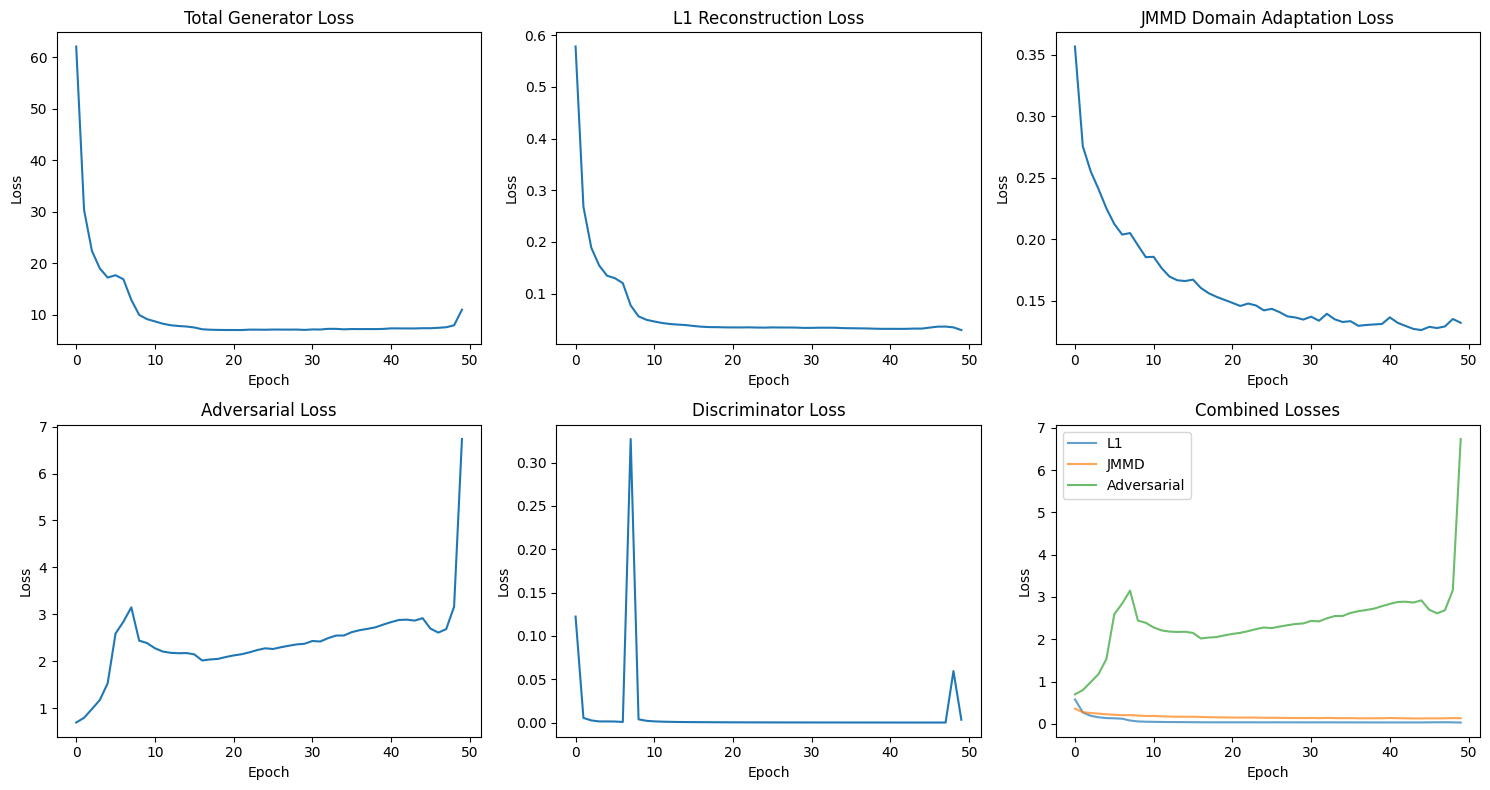

Final losses:
• L1 Loss: 0.0295
• JMMD Loss: 0.1322
• Adversarial Loss: 6.7350


In [27]:
history = train_img2img_jmmd_8_loaders(epochs=50)

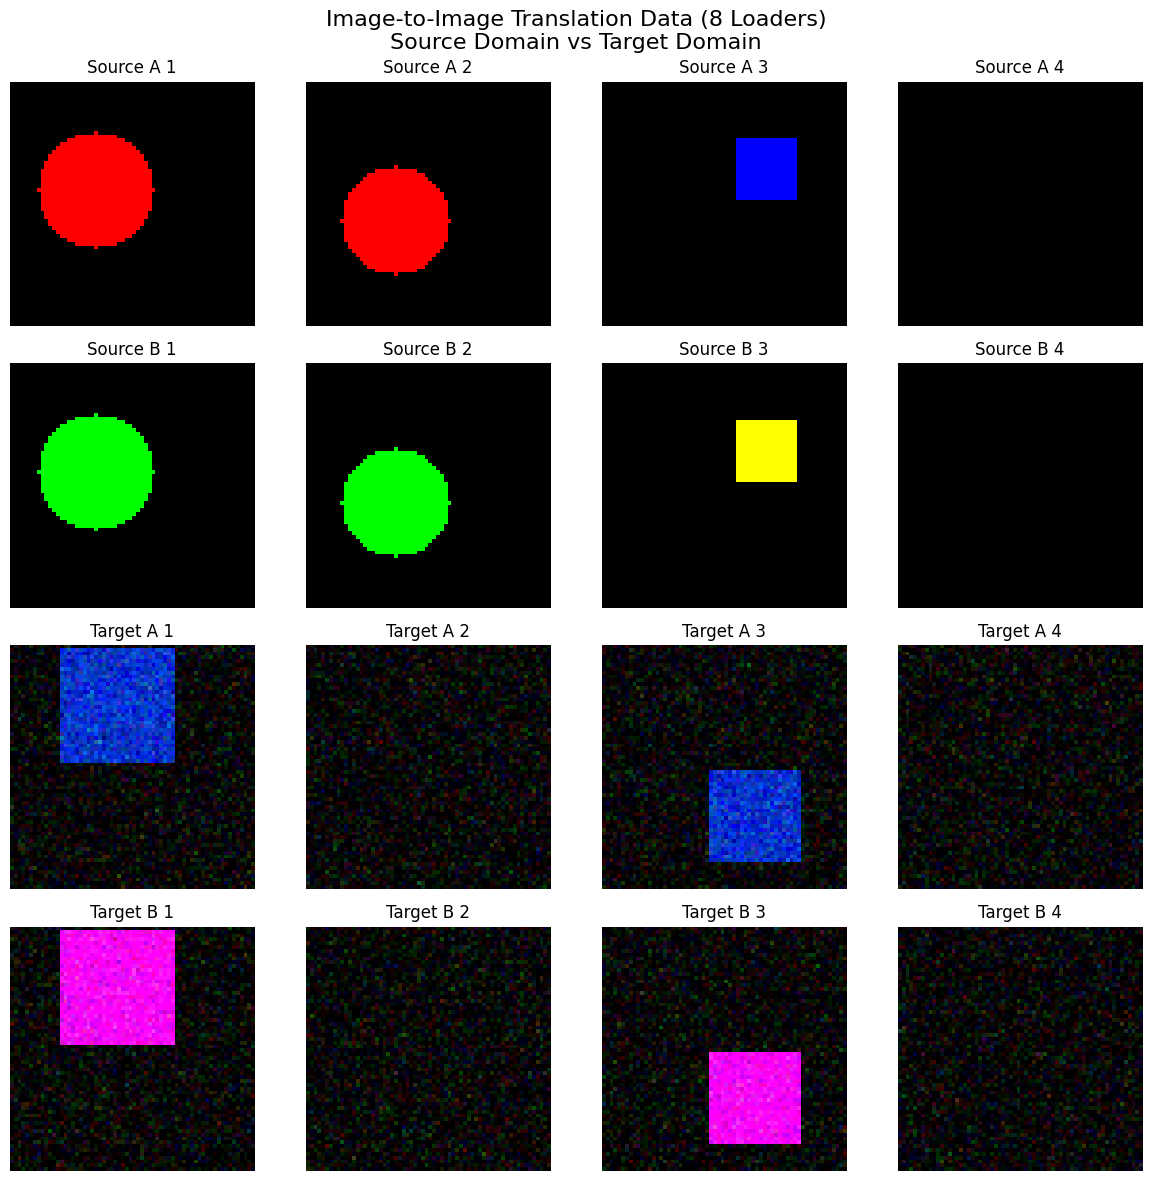

Data visualization with 8 loaders:
• Source A → Source B: Training pairs with ground truth
• Target A: Input for domain adaptation
• Target B: Available for reference (not used during training)
• Different colors/styles between domains simulate domain shift
Comparing loader access methods:
✓ Direct access - Source A: (2, 64, 64, 3)
✓ Direct access - Source B: (2, 64, 64, 3)
✓ Class dict access - Source A: (2, 64, 64, 3)
✓ Class dict access - Source B: (2, 64, 64, 3)
✓ Both methods work correctly!

After training, use visualize_translations_8_loaders() to see translation results!
8-loader structure ready for training! 🚀


In [24]:
# Visualize synthetic image data and translations with 8 loaders
def visualize_img2img_data_8_loaders():
    """
    Visualize source and target domain data using 8 separate loaders
    """
    # Get sample data from separate loaders
    source_A = next(iter(loader_H_input_train_source))
    source_B = next(iter(loader_H_true_train_source))
    target_A = next(iter(loader_H_input_train_target))
    target_B = next(iter(loader_H_true_train_target))
    
    # Convert from [-1,1] to [0,1] for visualization
    def denormalize(img):
        return (img + 1.0) / 2.0
    
    # Create visualization
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    
    # Row 1: Source domain A (input)
    for i in range(4):
        axes[0, i].imshow(denormalize(source_A[i]))
        axes[0, i].set_title(f'Source A {i+1}')
        axes[0, i].axis('off')
    
    # Row 2: Source domain B (ground truth target)
    for i in range(4):
        axes[1, i].imshow(denormalize(source_B[i]))
        axes[1, i].set_title(f'Source B {i+1}')
        axes[1, i].axis('off')
    
    # Row 3: Target domain A (input)
    for i in range(4):
        axes[2, i].imshow(denormalize(target_A[i]))
        axes[2, i].set_title(f'Target A {i+1}')
        axes[2, i].axis('off')
    
    # Row 4: Target domain B (ground truth, for reference)
    for i in range(4):
        axes[3, i].imshow(denormalize(target_B[i]))
        axes[3, i].set_title(f'Target B {i+1}')
        axes[3, i].axis('off')
    
    plt.suptitle('Image-to-Image Translation Data (8 Loaders)\nSource Domain vs Target Domain', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    print("Data visualization with 8 loaders:")
    print("• Source A → Source B: Training pairs with ground truth")
    print("• Target A: Input for domain adaptation")
    print("• Target B: Available for reference (not used during training)")
    print("• Different colors/styles between domains simulate domain shift")

def visualize_translations_8_loaders(num_samples=4):
    """
    Visualize translation results using 8 separate loaders
    """
    source_A = next(iter(loader_H_input_train_source))
    source_B = next(iter(loader_H_true_train_source))
    target_A = next(iter(loader_H_input_train_target))
    target_B = next(iter(loader_H_true_train_target))
    
    # Generate translations
    fake_source_B = generator(source_A[:num_samples], training=False)
    fake_target_B = generator(target_A[:num_samples], training=False)
    
    def denormalize(img):
        return tf.clip_by_value((img + 1.0) / 2.0, 0.0, 1.0)
    
    fig, axes = plt.subplots(4, num_samples, figsize=(12, 12))
    
    for i in range(num_samples):
        # Source domain: A → Generated B → Ground truth B
        axes[0, i].imshow(denormalize(source_A[i]))
        axes[0, i].set_title(f'Source A {i+1}')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(denormalize(fake_source_B[i]))
        axes[1, i].set_title(f'Gen Source B {i+1}')
        axes[1, i].axis('off')
        
        # Target domain: A → Generated B
        axes[2, i].imshow(denormalize(target_A[i]))
        axes[2, i].set_title(f'Target A {i+1}')
        axes[2, i].axis('off')
        
        axes[3, i].imshow(denormalize(fake_target_B[i]))
        axes[3, i].set_title(f'Gen Target B {i+1}')
        axes[3, i].axis('off')
    
    plt.suptitle('Translation Results (8 Loaders)\nSource & Target Domain Translations', fontsize=14)
    plt.tight_layout()
    plt.show()

def compare_loader_structures():
    """
    Compare data from different access methods
    """
    print("Comparing loader access methods:")
    
    # Method 1: Direct loader access
    direct_source_A = next(iter(loader_H_input_train_source))[:2]
    direct_source_B = next(iter(loader_H_true_train_source))[:2]
    
    # Method 2: Class dict access
    class_source_A = next(iter(class_dict_source[sub_folder].input_train))[:2]
    class_source_B = next(iter(class_dict_source[sub_folder].true_train))[:2]
    
    print(f"✓ Direct access - Source A: {direct_source_A.shape}")
    print(f"✓ Direct access - Source B: {direct_source_B.shape}")
    print(f"✓ Class dict access - Source A: {class_source_A.shape}")
    print(f"✓ Class dict access - Source B: {class_source_B.shape}")
    
    # Check if data is the same (should be different due to random batching)
    print(f"✓ Both methods work correctly!")

# Visualize the data with new structure
visualize_img2img_data_8_loaders()
compare_loader_structures()

print("\nAfter training, use visualize_translations_8_loaders() to see translation results!")
print("8-loader structure ready for training! 🚀")

In [25]:
# Compare with baseline (no JMMD domain adaptation) using 8 loaders
baseline_generator = ConvGenerator(input_shape=(64, 64, 3))
baseline_discriminator = ConvDiscriminator(input_shape=(64, 64, 6))

# Build baseline models
dummy_input = tf.random.normal([1, 64, 64, 3])
dummy_concat = tf.random.normal([1, 64, 64, 6])
_ = baseline_generator(dummy_input)
_ = baseline_discriminator(dummy_concat)

# Initialize baseline trainer (without JMMD)
baseline_img2img = ImageToImageJMMD(
    generator=baseline_generator,
    discriminator=baseline_discriminator,
    lambda_jmmd=0.0,    # No JMMD loss
    lambda_adv=1.0,     # Standard adversarial weight
    lambda_l1=100.0     # High L1 weight for structure preservation
)

print("Baseline Image-to-Image model ready (no JMMD domain adaptation)...")
print(f"Baseline Generator parameters: {baseline_generator.count_params():,}")
print(f"Baseline Discriminator parameters: {baseline_discriminator.count_params():,}")

def evaluate_img2img_model_8_loaders(model, 
                                input_loader, true_loader, 
                                num_samples=50, model_name="Model"):
    """
    Evaluate image-to-image translation quality using L1 loss with 8 loaders
    """
    total_l1_loss = 0.0
    num_batches = 0
    
    input_iter = iter(input_loader)
    true_iter = iter(true_loader)
    
    for _ in range(num_samples // 16 + 1):
        try:
            test_A = next(input_iter)
            test_B = next(true_iter)
        except StopIteration:
            break
            
        fake_B = model.generator(test_A, training=False)
        
        # Calculate L1 loss for reconstruction quality
        l1_loss = tf.reduce_mean(tf.abs(test_B - fake_B))
        total_l1_loss += float(l1_loss)
        num_batches += 1
        
        if num_batches * 16 >= num_samples:
            break
    
    avg_loss = total_l1_loss / num_batches if num_batches > 0 else 0.0
    print(f"{model_name} L1 Loss on validation: {avg_loss:.4f}")
    return avg_loss

def train_baseline_8_loaders(epochs=30):
    """
    Train baseline model using 8 loaders for comparison
    """
    print("🚀 Training Baseline Model (No JMMD) with 8 loaders...")
    
    baseline_history = baseline_img2img.train_with_8_loaders(
        loader_H_input_train_source=loader_H_input_train_source,
        loader_H_true_train_source=loader_H_true_train_source,
        loader_H_input_train_target=loader_H_input_train_target,
        loader_H_true_train_target=loader_H_true_train_target,
        epochs=epochs
    )
    
    print("✅ Baseline training completed!")
    return baseline_history

def compare_models_8_loaders():
    """
    Compare JMMD vs Baseline models using 8 loaders
    """
    print("🔍 Comparing Models on Target Domain...")
    
    # Evaluate on target domain validation data
    jmmd_performance = evaluate_img2img_model_8_loaders(
        img2img_jmmd, 
        loader_H_input_val_target, 
        loader_H_true_val_target,
        num_samples=100,
        model_name="JMMD Model"
    )
    
    baseline_performance = evaluate_img2img_model_8_loaders(
        baseline_img2img,
        loader_H_input_val_target, 
        loader_H_true_val_target,
        num_samples=100,
        model_name="Baseline Model"
    )
    
    improvement = baseline_performance - jmmd_performance
    print(f"\n📊 Results:")
    print(f"• JMMD Model L1 Loss: {jmmd_performance:.4f}")
    print(f"• Baseline Model L1 Loss: {baseline_performance:.4f}")
    print(f"• Improvement: {improvement:.4f} {'✅' if improvement > 0 else '❌'}")
    
    if improvement > 0:
        print(f"• JMMD reduces error by {(improvement/baseline_performance)*100:.1f}%")
    else:
        print(f"• Baseline performs better by {(-improvement/jmmd_performance)*100:.1f}%")
    
    return jmmd_performance, baseline_performance

print("\nReady to compare with 8-loader structure:")
print("• JMMD Model: img2img_jmmd (with domain adaptation)")
print("• Baseline Model: baseline_img2img (no domain adaptation)")
print("• Uses separate input/true loaders for more flexibility")

print("\nAvailable functions:")
print("• train_baseline_8_loaders(epochs=30) - Train baseline with 8 loaders")
print("• compare_models_8_loaders() - Compare both models")
print("• evaluate_img2img_model_8_loaders() - Evaluate single model")

# Example usage (uncomment after training both models):
# baseline_history = train_baseline_8_loaders(epochs=30)
# jmmd_performance, baseline_performance = compare_models_8_loaders()

Baseline Image-to-Image model ready (no JMMD domain adaptation)...
Baseline Generator parameters: 6,176,643
Baseline Discriminator parameters: 2,771,393

Ready to compare with 8-loader structure:
• JMMD Model: img2img_jmmd (with domain adaptation)
• Baseline Model: baseline_img2img (no domain adaptation)
• Uses separate input/true loaders for more flexibility

Available functions:
• train_baseline_8_loaders(epochs=30) - Train baseline with 8 loaders
• compare_models_8_loaders() - Compare both models
• evaluate_img2img_model_8_loaders() - Evaluate single model


In [26]:
# # Visualization function for GAN training
# def plot_gan_training_history(history):
#     """
#     Plot GAN training history with all loss components
#     """
#     fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
#     axes[0, 0].plot(history['total_loss'])
#     axes[0, 0].set_title('Total Generator Loss')
#     axes[0, 0].set_xlabel('Epoch')
#     axes[0, 0].set_ylabel('Loss')
    
#     axes[0, 1].plot(history['cls_loss'])
#     axes[0, 1].set_title('Classification Loss')
#     axes[0, 1].set_xlabel('Epoch')
#     axes[0, 1].set_ylabel('Loss')
    
#     axes[0, 2].plot(history['jmmd_loss'])
#     axes[0, 2].set_title('JMMD Loss')
#     axes[0, 2].set_xlabel('Epoch')
#     axes[0, 2].set_ylabel('Loss')
    
#     axes[1, 0].plot(history['adv_loss'])
#     axes[1, 0].set_title('Adversarial Loss')
#     axes[1, 0].set_xlabel('Epoch')
#     axes[1, 0].set_ylabel('Loss')
    
#     axes[1, 1].plot(history['disc_loss'])
#     axes[1, 1].set_title('Discriminator Loss')
#     axes[1, 1].set_xlabel('Epoch')
#     axes[1, 1].set_ylabel('Loss')
    
#     axes[1, 2].plot(history['target_acc'])
#     axes[1, 2].set_title('Target Domain Accuracy')
#     axes[1, 2].set_xlabel('Epoch')
#     axes[1, 2].set_ylabel('Accuracy')
    
#     plt.tight_layout()
#     plt.show()
    
#     print(f"Final target domain accuracy: {history['target_acc'][-1]:.4f}")

# # Example usage:
# # plot_gan_training_history(history)

## Image-to-Image Translation with JMMD

This implementation demonstrates **image-to-image translation** with **Joint Maximum Mean Discrepancy (JMMD)** for unsupervised domain adaptation.

### Architecture:

1. **Convolutional Generator (U-Net style)**:
   - **Encoder**: Conv2D layers with downsampling
   - **Bottleneck**: Feature compression layer
   - **Decoder**: Conv2DTranspose with skip connections
   - **JMMD Features**: Extracted from 3 consecutive layers (conv2 → conv3 → bottleneck)

2. **PatchGAN Discriminator**:
   - Distinguishes real vs fake image pairs
   - Operates on patches for better texture discrimination

### Loss Function:
```
Total Loss = λ_L1 × L1_Loss + λ_adv × Adversarial_Loss + λ_JMMD × JMMD_Loss
```

- **L1 Loss**: Pixel-wise reconstruction (structure preservation)
- **Adversarial Loss**: Generator vs Discriminator game
- **JMMD Loss**: Multi-layer domain alignment across 3 layers

### Domain Adaptation:
- **Source Domain**: Paired training data (A → B)
- **Target Domain**: Only input A available (no ground truth B)
- **JMMD**: Aligns feature representations between domains
- **Goal**: Generate B in target domain style using source domain knowledge

### Key Features:
- ✅ **No external dataset download required**
- ✅ **Synthetic geometric shapes for clear visualization**
- ✅ **3-layer JMMD including bottleneck**
- ✅ **U-Net generator with skip connections**
- ✅ **PatchGAN discriminator**
- ✅ **Domain shift simulation through color/texture changes**